In [ ]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix, random as sparse_random
import matplotlib.pyplot as plt

def qubosolver(A, b):
    # Start tracing memory allocations
    tracemalloc.start()
    start_time = time.time()

    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Add variables
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-4d20b60b0faf5516868e16417928459ad087bd50'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()
    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Convert bytes to MB
    memory_used = peak / (1024 ** 2)
    time_taken = end_time - start_time

    print(f"Solution: {sol_sample}")
    print(f"Peak Memory Used: {memory_used:.2f} MB")
    print(f"Time Taken: {time_taken:.6f} seconds")

    return sol_sample, memory_used, time_taken

def test_scalability():
    matrix_sizes = []
    memory_usage = []
    time_taken = []
    #sizes = [10, 50, 100, 500, 1000, 1500, 2000 ,4000, 6000, 8000, 10000 ,20000, 40000, 60000, 80000 ,100000, 120000, 140000, 160000, 180000, 200000]
    sizes= [10, 20 , 40,60,80,100,120,140,160,180,200,220, 240, 260,280,300, 320,340,360,380,400]
    try:
        for size in sizes: 
            print(f"Running for matrix size {size}x{size}")
            A = sparse_random(size, size, 0.01)
            b = np.zeros(size)  # Random linear terms

            sol, memory, t = qubosolver(A, b)
            matrix_sizes.append(size)
            time_taken.append(t)
            memory_usage.append(memory)

    except KeyboardInterrupt:
        print("Process interrupted by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(matrix_sizes, time_taken, marker='o', label='Time (seconds)')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Time (seconds)')
        plt.title('Matrix Size vs Time')

        plt.subplot(2, 1, 2)
        plt.plot(matrix_sizes, memory_usage, marker='o', label='Peak Memory Usage (MB)', color='orange')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Memory (MB)')
        plt.title('Matrix Size vs Memory Usage')

        plt.tight_layout()
        plt.show()

test_scalability()

Running for matrix size 10x10
Solution: [1 0 0 0 0 0 1 1 1 1]
Peak Memory Used: 41.36 MB
Time Taken: 3.927836 seconds
Running for matrix size 20x20
Solution: [0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0]
Peak Memory Used: 39.98 MB
Time Taken: 2.846376 seconds
Running for matrix size 40x40
Solution: [1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1
 0 1 1]
Peak Memory Used: 39.94 MB
Time Taken: 3.458388 seconds
Running for matrix size 60x60
Solution: [1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1
 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1]
Peak Memory Used: 39.94 MB
Time Taken: 2.971266 seconds
Running for matrix size 80x80
Solution: [0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0
 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1
 1 1 0 0 0 1]
Peak Memory Used: 39.93 MB
Time Taken: 3.323948 seconds
Running for matrix size 100x100
Solution: [1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1

Running for matrix size 10x10
Solution: [1 1 1 1 0 0 1 0 1 1]
Memory used: 3.10 MB (Peak: 33.03 MB)
Time: 19.718619 seconds
Running for matrix size 50x50
Solution: [0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1
 0 0 1 0 1 1 0 0 0 0 0 0 1]
Memory used: 0.52 MB (Peak: 30.69 MB)
Time: 17.585014 seconds
Running for matrix size 100x100
Solution: [0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1]
Memory used: 0.52 MB (Peak: 30.69 MB)
Time: 17.021498 seconds
Running for matrix size 500x500
Solution: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0
 0 0 1 1 1 0 0 0 1 0 

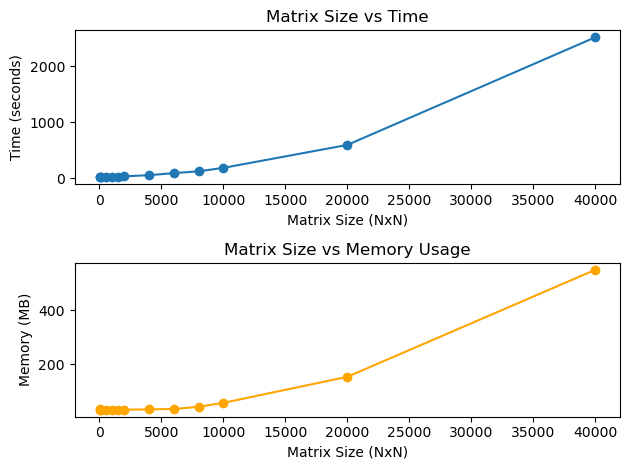

In [ ]:
import numpy as np
import time
import tracemalloc
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from scipy.sparse import csc_matrix
import dimod
from dwave.system import LeapHybridSampler
import os

os.environ['DWAVE_API_TOKEN'] = 'DEV-031741f1792495e220d4d55aeb72ab7961cc16cd'

def qubosolverHr(A, b):
    tracemalloc.start()
    start_time = time.time()
    A = csc_matrix(A)
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})
    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    
    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)
    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    memory_used_mb = current / (1024 ** 2)
    peak_memory_used_mb = peak / (1024 ** 2)
    end_time = time.time()

    # Calculate time taken
    time_taken = end_time - start_time

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    print(f"Memory used: {memory_used_mb:.2f} MB (Peak: {peak_memory_used_mb:.2f} MB)")
    print(f"Time: {time_taken:.6f} seconds")

    return sol_sample, time_taken, peak_memory_used_mb


def test_scalability():
    matrix_sizes = []
    memory_usage = []
    time_taken = []
    #sizes = [10, 50, 100, 500, 1000, 1500, 2000 ,4000, 6000, 8000, 10000 ,20000, 40000, 60000, 80000 ,100000, 120000, 140000, 160000, 180000, 200000]
    sizes= [10, 20 , 40]
    try:
        for size in sizes: 
            print(f"Running for matrix size {size}x{size}")
            A = sparse_random(size)
            b = np.zeros(size)  # Random linear terms

            sol, t, memory = qubosolverHr(A, b)
            matrix_sizes.append(size)
            time_taken.append(t)
            memory_usage.append(memory)

    except KeyboardInterrupt:
        print("Process interrupted by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(matrix_sizes, time_taken, marker='o', label='Time (seconds)')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Time (seconds)')
        plt.title('Matrix Size vs Time')

        plt.subplot(2, 1, 2)
        plt.plot(matrix_sizes, memory_usage, marker='o', label='Peak Memory Usage (MB)', color='orange')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Memory (MB)')
        plt.title('Matrix Size vs Memory Usage')

        plt.tight_layout()
        plt.show()

test_scalability()


In [2]:
from dwave.samplers import SimulatedAnnealingSampler
import scipy.sparse as sp
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix, random as sparse_random
import matplotlib.pyplot as plt


Running for matrix size 10x10
Solution:[0 0 1 0 0 0 1 0 1 0]
Running for matrix size 50x50
Solution:[0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0
 1 0 0 1 0 0 1 0 0 0 0 0 1]
Running for matrix size 100x100
Solution:[0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0
 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1]
Running for matrix size 500x500
Solution:[1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 

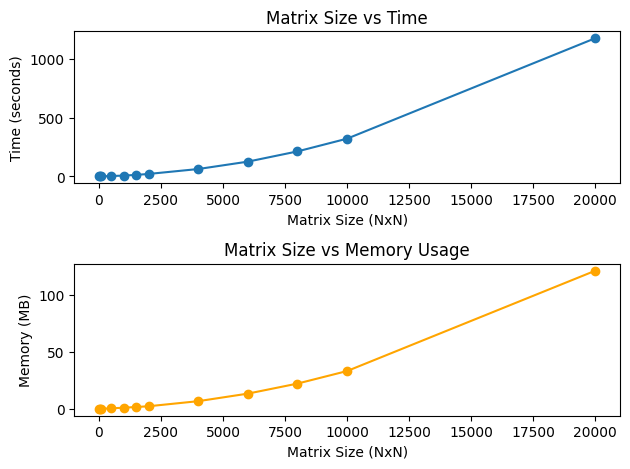

In [5]:

def sparse_random(size, density=0.01):
    """Generate a sparse binary matrix of given size with specified density."""
    return sp.random(size, size, density=density, format='csr', dtype=np.int8).astype(bool)


def qubosolverSA(A, b):
    tracemalloc.start()
    start_time = time.time()
    #Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_memory= peak / (1024 ** 2)
    end_time = time.time()

    # Calculate time taken
    timee = end_time - start_time


    print(f"Solution:{sol_sample}")


    return sol_sample, timee, peak_memory


def test_scalability():
    matrix_sizes = []
    memory_usage = []
    time_taken = []
    sizes = [10, 50, 100, 500, 1000, 1500, 2000 ,4000, 6000, 8000, 10000 ,20000, 40000, 60000, 80000 ,100000, 120000, 140000, 160000, 180000, 200000]
    #sizes= [2,3,4]
    try:
        for size in sizes: 
            print(f"Running for matrix size {size}x{size}")
            A = sparse_random(size)
            b = np.zeros(size)  # Random linear terms

            sol, t, memory = qubosolverSA(A, b)
            matrix_sizes.append(size)
            time_taken.append(t)
            memory_usage.append(memory)

    except KeyboardInterrupt:
        print("Process interrupted by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(matrix_sizes, time_taken, marker='o', label='Time (seconds)')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Time (seconds)')
        plt.title('Matrix Size vs Time')

        plt.subplot(2, 1, 2)
        plt.plot(matrix_sizes, memory_usage, marker='o', label='Peak Memory Usage (MB)', color='orange')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Memory (MB)')
        plt.title('Matrix Size vs Memory Usage')

        plt.tight_layout()
        plt.show()

test_scalability()